In [8]:
import torch
import captum
import torchvision
import matplotlib.pyplot as plt

from train import load_model, get_conv_layers_step
from core import EvalSurrogateModel


DEVICE = "cpu"

normalization = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

sample = torchvision.io.read_image("sample.jpg").float() / 255.0
sample = sample.to(DEVICE).unsqueeze(dim=0)
normalized_sample = normalization(sample)


/home/rherdt/anaconda3/envs/pytorch_cu11/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/rherdt/anaconda3/envs/pytorch_cu11/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


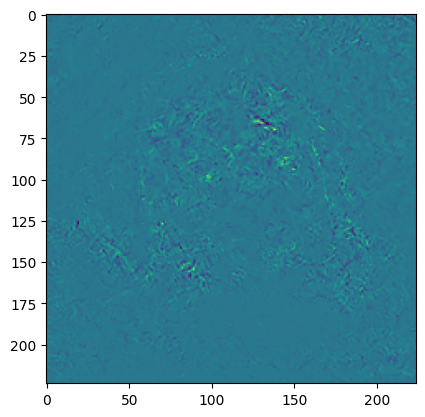

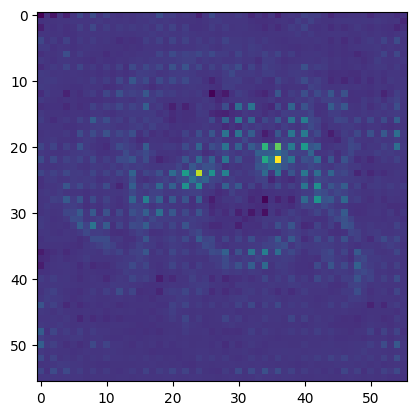

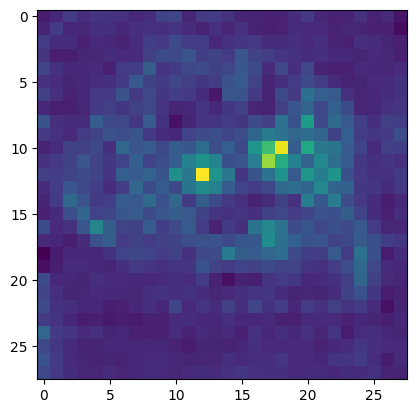

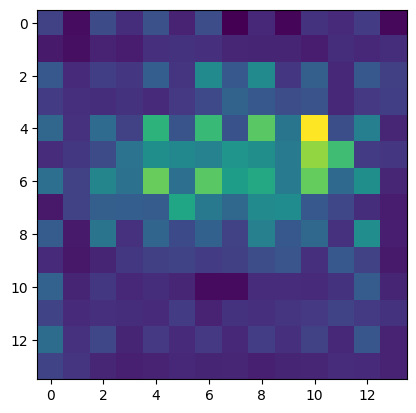

In [11]:
# ------------------------------- original model -----------------------------------------

model = load_model("resnet34").to(DEVICE)

saliency_method = captum.attr.DeepLift(model, multiply_by_inputs=True)
baseline = torch.tensor([0.0, 0.0, 0.0]).unsqueeze(dim=0).unsqueeze(dim=-1).unsqueeze(dim=-1).to(DEVICE) * torch.ones_like(sample)

grad = saliency_method.attribute(normalized_sample, target=207, baselines=baseline)[0].detach().cpu()
plt.figure()
plt.imshow(torch.mean(grad, dim=[0]))


# plot saliency maps for hidden layers for the original model

layer_names = ["layer1", "layer2", "layer3"]
for layer_name in layer_names:
    saliency_method = captum.attr.LayerDeepLift(model, layer=eval("model." + layer_name), multiply_by_inputs=True)
    grad = saliency_method.attribute(normalized_sample, target=207, baselines=baseline)[0].detach().cpu()
    plt.figure()
    plt.imshow(torch.mean(grad, dim=[0]))

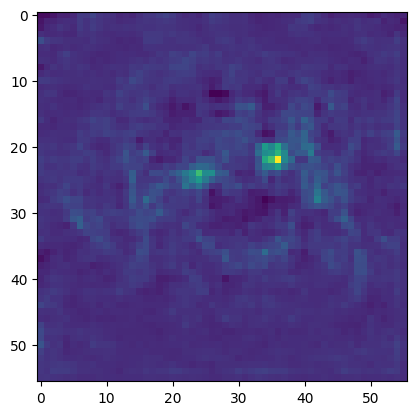

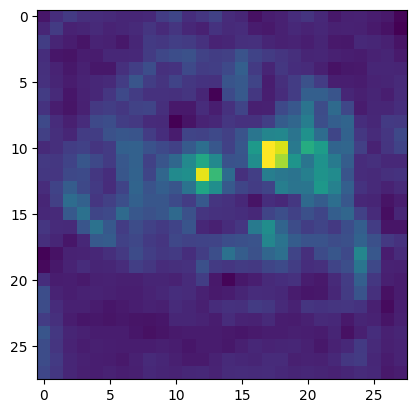

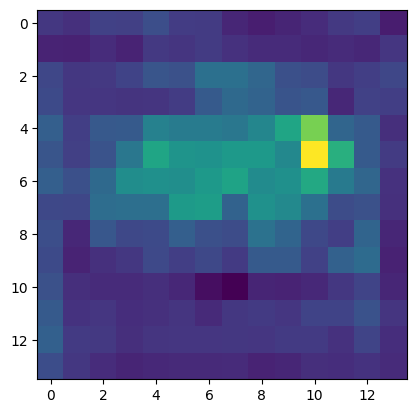

In [10]:
# ---------------------- bilinear surrogate -----------------------------------

model = load_model("resnet34").to(DEVICE)

hook_points = []
convolutions = torch.load("ckpts/resnet34/0010.pt").to(DEVICE)
get_conv_layers_step(model, hook_points)

network = EvalSurrogateModel(model, hook_points=hook_points, surrogate_convolutions=convolutions, is_stitched_classifier=False)
network = network.to(DEVICE)
network = network.eval()

# plot saliency maps for hidden layers for the bilinear surrogate model,
# inside EvalSurrogateModel all the convolutional downsamplings of the model get hooked and replaced by the bilinear surrogate paths
layer_names = ["layer1", "layer2", "layer3"]
for layer_name in layer_names:
    saliency_method = captum.attr.LayerDeepLift(model, layer=eval("model." + layer_name), multiply_by_inputs=True)
    grad = saliency_method.attribute(normalized_sample, target=207, baselines=baseline)[0].detach().cpu()
    plt.figure()
    plt.imshow(torch.mean(grad, dim=[0]))

/home/rherdt/anaconda3/envs/pytorch_cu11/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rherdt/anaconda3/envs/pytorch_cu11/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/rherdt/anaconda3/envs/pytorch_cu11/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_ful

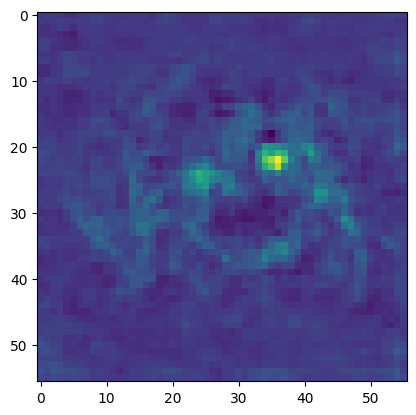

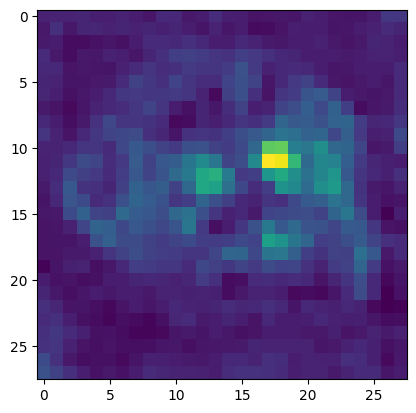

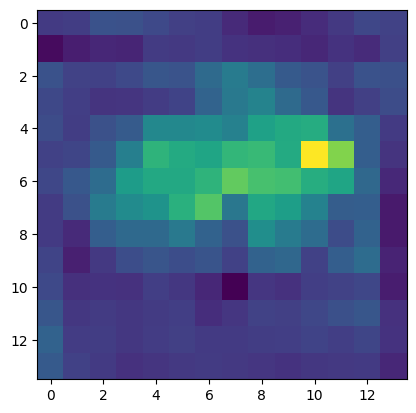

In [9]:
# ---------------------- backward hook -----------------------------------

#----------------- backward hook, copied over from eval_.py ----------------
def conv_backward_hook_grad_fix(module, grad_input, grad_output):
    accumulated_grad = None

    for h in range(2):
        for w in range(2):
            rolled_grad = torch.roll(grad_input[0], shifts=[h, w], dims=[2, 3])
            if accumulated_grad is None:
                accumulated_grad = rolled_grad
            else:
                accumulated_grad += rolled_grad

    return (accumulated_grad/4.0, grad_input[1], grad_input[2])


def backward_fix_hook_model(model):
    hook_points = []
    get_conv_layers_step(model, hook_points)
    for conv_layer in hook_points:
        conv_layer.register_backward_hook(conv_backward_hook_grad_fix)
#------------------------------------------------------------------------



model = load_model("resnet34").to(DEVICE)
backward_fix_hook_model(model)

layer_names = ["layer1", "layer2", "layer3"]
for layer_name in layer_names:
    saliency_method = captum.attr.LayerDeepLift(model, layer=eval("model." + layer_name), multiply_by_inputs=True)
    grad = saliency_method.attribute(normalized_sample, target=207, baselines=baseline)[0].detach().cpu()
    plt.figure()
    plt.imshow(torch.mean(grad, dim=[0]))